In [49]:
import pickle
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sn
#from sklearn.model_selection import train_test_split,  StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix
import fasttext
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [45]:
!pip install fasttext==0.9.2

In [3]:
def input2fasstext(df, text_column, target_column):
    df['ftdata'] = '__label__' + df[target_column].astype('str') + ' ' + df[text_column]
    return df

def parse_top_k(path):
    arr = []
    with open(path) as f:
        for line in f.readlines():
            # print(line)
            arr.append(np.array([int(i) for i in re.findall(r'[\d\.]+', line)]))
            # print(arr)
    return (np.array(arr))

def top_k(X, y):
    m, k = X.shape
    count = 0
    for i in range(m):
        if y[i] in X[i]:
            count += 1
    return count / float(m)

In [50]:
df = pd.read_csv('data/preprocessed_case_study_data.csv')
with open('data/val_indices.pickle', 'rb') as f:
    val_ind = pickle.load(f)

In [51]:
df['label'] = df.product_group.factorize()[0]

In [11]:
df = input2fasstext(df, 'prep_text', 'label')

In [50]:
df.head()

,complaint_id,product_group,text,clean_text,prep_text,label
0,2815595,bank_service,On XX/XX/2017 my check # XXXX was debited from...,on xxxx my check xxxx was debited from my che...,xxxx check xxxx debited checking account check...,0
1,2217937,bank_service,I opened a Bank of the the West account. The a...,i opened a bank of the west account the accou...,opened bank west account account came promotio...,0
2,2657456,bank_service,wells fargo in nj opened a business account wi...,wells_fargo in nj opened a business account wi...,wells_fargo nj opened business account without...,0
3,1414106,bank_service,A hold was placed on my saving account ( XXXX ...,a hold was placed on my saving account xxxx ...,hold placed saving account xxxx institution sa...,0
4,1999158,bank_service,Dear CFPB : I need to send a major concern/com...,dear cfpb i need to send a major concerncompl...,dear cfpb need send major concerncomplaint fal...,0


In [15]:
train = df.loc[~df.complaint_id.isin(val_ind)]
test = df.loc[df.complaint_id.isin(val_ind)]
train['ftdata'].to_csv('data/train_ft', index = False)
test['ftdata'].to_csv('data/val_ft', index = False)

In [18]:
!fastText-0.9.2/./fasttext  supervised -input data/train_ft -output models/fasttext/ft_rav 

Read 23M words
Number of words:  105057
Number of labels: 7
Progress: 100.0% words/sec/thread: 2433872 lr:  0.000000 avg.loss:  0.570915 ETA:   0h 0m 0s


In [21]:
!fastText-0.9.2/./fasttext  predict models/fasttext/ft_rav.bin data/val_ft 1 >> models/fasttext/ft_raw_preds

In [35]:
top_1 = parse_top_k('models/fasttext/ft_raw_preds')[1:]


In [ ]:
map_dct = {'bank_service': 0,
          'credit_card': 1,
          'credit_reporting': 2,
          'debt_collection': 3,
          'loan': 4,
          'money_transfers': 5,
          'mortgage': 6}

with open('label_mapping.pickle', 'wb') as f:
    pickle.dump(map_dct, f)

In [57]:
print(classification_report(np.array(test.label), top_1.squeeze(), target_names = map_dct.keys()))

                  precision    recall  f1-score   support

    bank_service       0.90      0.64      0.74      2007
     credit_card       0.69      0.87      0.77      2955
credit_reporting       0.87      0.85      0.86      8123
 debt_collection       0.84      0.81      0.83      6146
            loan       0.77      0.83      0.80      3104
 money_transfers       0.91      0.53      0.67       473
        mortgage       0.91      0.93      0.92      4028

        accuracy                           0.83     26836
       macro avg       0.84      0.78      0.80     26836
    weighted avg       0.84      0.83      0.83     26836



[[1278  477   48   39   70   19   76]
 [  34 2564  186  106   48    5   12]
 [  14  277 6918  517  294    0  103]
 [  15  173  561 4983  308    0  106]
 [   9   94  178  198 2579    1   45]
 [  61  103   10   11   12  253   23]
 [  14   31   95   65   58    1 3764]]


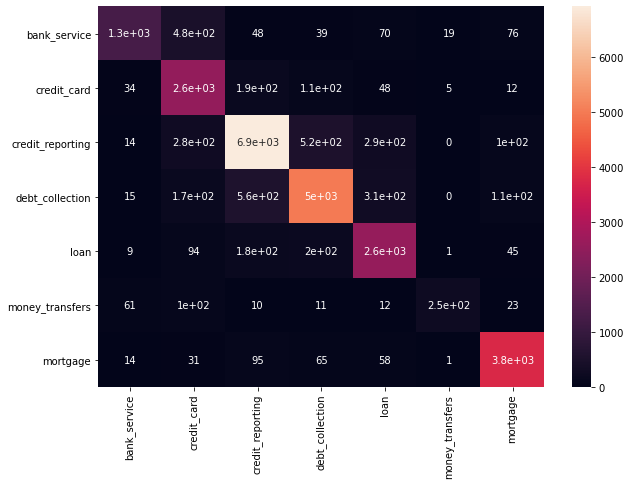

In [66]:
cm = confusion_matrix(np.array(test.label), top_1.squeeze())
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in map_dct.keys()],
                  columns = [i for i in map_dct.keys()])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
## Cross validation

In [46]:
!fastText-0.9.2/./fasttext supervised -input data/train_ft -output models/ft_best_new -autotune-validation data/val_ft

Progress: 100.0% Trials:    9 Best score:  0.856163 ETA:   0h 0m 0s
Training again with best arguments
Read 23M words
Number of words:  105057
Number of labels: 7
Progress: 100.0% words/sec/thread: 1224634 lr:  0.000000 avg.loss:  0.118022 ETA:   0h 0m 0s


In [47]:
!fastText-0.9.2/./fasttext  predict models/fasttext/ft_best_new.bin data/val_ft 1 >> models/fasttext/ft_best_preds_new

terminate called after throwing an instance of 'std::invalid_argument'
  what():  models/fasttext/ft_best_new.bin cannot be opened for loading!
Aborted


In [16]:
import re
top_1 = parse_top_k('models/fasttext/ft_best_preds')[1:]

In [19]:
df = pd.read_csv('data/preprocessed_case_study_data.csv')
with open('data/val_indices.pickle', 'rb') as f:
    val_ind = pickle.load(f)
    
train = df.loc[~df.complaint_id.isin(val_ind)]
test = df.loc[df.complaint_id.isin(val_ind)]


FastText best:
                  precision    recall  f1-score   support

    bank_service       0.79      0.82      0.81      2007
     credit_card       0.80      0.79      0.80      2955
credit_reporting       0.87      0.90      0.89      8123
 debt_collection       0.85      0.83      0.84      6146
            loan       0.82      0.79      0.81      3104
 money_transfers       0.81      0.71      0.75       473
        mortgage       0.93      0.93      0.93      4028

        accuracy                           0.85     26836
       macro avg       0.84      0.82      0.83     26836
    weighted avg       0.85      0.85      0.85     26836

[[1647  156   45   33   33   41   52]
 [ 168 2335  220  138   55   17   22]
 [  46  168 7342  357  145    5   60]
 [  39  119  565 5089  242    6   86]
 [  41   88  180  258 2465    9   63]
 [  87   20    6    7    8  335   10]
 [  53   15   97   76   54    2 3731]]


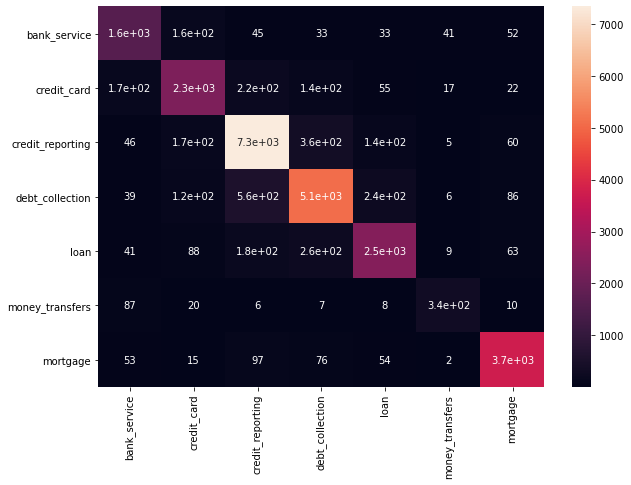

In [48]:
print('FastText best:')
print(classification_report(np.array(test.label), top_1.squeeze(), target_names = map_dct.keys()))
cm = confusion_matrix(np.array(test.label), top_1.squeeze())
print(cm)
df_cm = pd.DataFrame(cm, index = [i for i in map_dct.keys()],
                  columns = [i for i in map_dct.keys()])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)